# Transmission tutorial
This is a tutorial aimed to demonstrate simulating and calculating detectability for a basic case of Earth transiting a host star 5 pc away using the SPECTR framework.

## Step 1: import modules that we will need

In [1]:
import numpy as np
import pickle
import astropy.units as unit
import sys
sys.path.append("/gscratch/vsm/mcurr/PACKAGES/") # this should be the path where SPECTR is downloaded
import high_res_tools as hrt
import math
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt

## Step 2: define parameters for the system in question
This is only for using SMART spectra. 

In [2]:
star = "trap1"
env = "pie" # environment is pre-industrial earth
molecule = "o2"
band = "1270" # absorption feature in nm
RV_system = 20 # radial velocity of system in km/s
RV_bary = 2 # barycentric radial velocity in km/s
incl = 90. # 90 degree inclination for transmission
obs_type = "tran" # we are calculating transmission spectroscopy
add_clouds = False # we are not adding clouds for now
resolution = 100000 # spectral resolving power of 100k 
tele_diam = 30 * unit.m # diameter of telescope in m
dist = 5.0 # distance to system in pc

# define some system properties
R_star = 0.1234 # radius of star in solar radii
P_rot_star = 82.6 # rotation period of star in days
P_orb = 348823.1855 # orbital period of planet in s
R_plan = 1.0 # radius of planet in earth radii
P_rot_plan = P_orb # synchronous rotator 
a_p = 0.027133822295365997 # semi-major axis of planet in AU
M_s = 0.082 # star mass in solar masses
M_p = 1 # planet mass

transit_duration = 60*60 # transit duration in s
texp = transit_duration # set the exposure time to be a full transit duration (only exposing one frame for this tutorial)

phases = np.array([90.])*unit.deg # only looking at one phase (when the planet is transiting)

nspec = len(phases) # number of exposures we are taking


## Step 3: Initiate an instance of SPECTR

In [3]:
observation = hrt.pipeline.SimulateObservation(star, env, molecule, band, obs_type, add_clouds=add_clouds, instrument_R=resolution)
observation.get_wl_bounds()

## Step 4: Load SMART spectra

In [4]:
# Note: the path will have to be to where your smart spectra are
observation.load_smart_spectra(path='/Users/mcurr/PROJECTS/terrestrial_HRCCS/metadata/smart_runs/{}_{}/tran/{}/'.format(star, env, molecule))


## Step 4a: If you do not have access to SMART spectra:
### You will have to manually assign the parameters:
- `observation.lam`
- `observation.fstar`
- `observation.fplan`
- `observation.fplan_no_mol`
- `observation.tdepth`
- `observation.tdepth_no_mol`
- `observation.tdepth_onlymol`
### Please see `observation.load_smart_spectra` for a description of these variables


## Step 5: Simulate an observation
Note: you will need skycalc_cli installed (https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html)
and you will need a directory `../metadata/sky/` created (or alter the source code at the skycalc.run_skycalc() line in pipeline.py to call the skycalc output file whatever you want)

In [5]:
# simulate initial observation
observation.run(incl,
                R_star,
                P_rot_star,
                P_orb, R_plan,
                P_rot_plan,
                a_p,
                M_s,
                M_p,
                RV_system,
                RV_bary,
                texp,
                phases,
                dist,
                tele_diam.value)

assert ~np.isnan(np.sum(observation.signal_matrix)), "There is a nan in the simulated data"
rvtot =  np.ones_like(phases.value)*(observation.RV_sys + observation.RV_bary )# make an array of the total RV shift

/Users/mcurr/PROJECTS/high_res_tools/manipulate_spectra.py:45: RuntimeWarning: invalid value encountered in sqrt
  kernel = c1 * np.sqrt(1.0 - lambda_ratio_sqr) + c2 * (1.0 - lambda_ratio_sqr)


SKYCALC output file already exists. Running with ../metadata/sky/skycalc_o2_1270.fits


## Step 6: Gather the signal/noise components

In [6]:
signal_per_night = observation.signal_matrix

# take care of any values less than zero
signal_less_zero = (signal_per_night < 0)
signal_per_night[signal_less_zero] = 0.

# out of transit:
signal_oot_per_night = observation.signal_oot_matrix
signal_oot_less_zero = (signal_oot_per_night < 0)
signal_oot_per_night[signal_oot_less_zero] = 0.    

#Noise:
read_noise_per_night = observation.read_noise[observation.data_naninds]
dark_noise_per_night = observation.dark_noise[observation.data_naninds]
sky_noise_per_night = observation.sky_noise[observation.data_naninds]



## Step 7: Define how many transits you want to observe and add appropriate noise

In [7]:
N_transits = 100 # let's observe 100 transits for this tutorial 

# in transit:
signal = signal_per_night * N_transits
noise = signal + sky_noise_per_night**2*N_transits + dark_noise_per_night**2*N_transits + read_noise_per_night**2*N_transits

# out of transit:
signal_oot = signal_oot_per_night * N_transits
noise_oot = signal_oot + sky_noise_per_night**2*N_transits + dark_noise_per_night**2*N_transits + read_noise_per_night**2*N_transits

# add simulated noise
poisson_draw = np.random.randn(signal.shape[0], signal.shape[1], signal.shape[2])
spec = signal + np.sqrt(noise)*poisson_draw # noisy spectrum in transit

poisson_draw_oot = np.random.randn(signal.shape[0], signal.shape[1], signal.shape[2])
spec_oot = signal_oot + np.sqrt(noise_oot)*poisson_draw_oot # noisy spectrum out of transit

# divide in and out of transit spectra to get rid of tellurics
obs_spec = spec / spec_oot


## Step 6: Congrats, you have simulated a spectrum! Let's plot it.

Text(0, 0.5, 'Transit depth')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


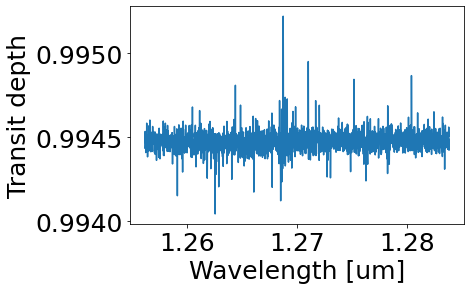

In [8]:
plt.figure()
plt.plot(observation.instrument_lam[0, 10:-10], obs_spec[0, 0, 10:-10])
plt.xlabel("Wavelength [um]")
plt.ylabel("Transit depth")

# Now we will focus on detecting our molecule in this spectrum. We will compute a detection significance using a cross-correlation analysis

## Step 7: Run a high pass filter over the data do get rid of low-frequency trends
Note: you can do fancy things here to reject outliers, but for now we will run a high pass filter on the data without rejecting any outliers.

In [9]:
def run_hipass_phase_dep(arr):
    nbin = 100
    norders, nph, nlam = arr.shape


    bins = int(nlam / nbin)
    xb = np.arange(nbin)*bins + bins/2.0
    yb = np.zeros(nbin+2)
    xb = np.append(np.append(0,xb),nlam-1)
    for io in range(norders):
        for j in range(nph):
            for ib in range(nbin):
                imin = int(ib*bins)
                imax = int(imin + bins)
                yb[ib+1] = np.nanmean(arr[io,j,imin:imax])
                yb[0] = arr[io, j, 0]
                yb[-1] = arr[io, j, -1]
            cs_bin = splrep(xb,yb,s=0.0)
            fit = splev(np.arange(nlam),cs_bin,der=0)
            arr[io,j,] -= fit

    return arr

# hipass on data (no outlier rejection)
data_hipass = run_hipass_phase_dep(obs_spec)

### Step 7a: Run a high pass filter over the template spectrum


In [10]:
def run_hipass_single(arr):
    nbin = 100
    nlam = len(arr)
    bins = int(nlam / nbin)
    xb = np.arange(nbin)*bins + bins/2.0
    yb = np.zeros(nbin+2)
    xb = np.append(np.append(0,xb),nlam-1)
    for ib in range(nbin):
        imin = int(ib*bins)
        imax = int(imin + bins)
        yb[ib+1] = np.mean(arr[imin:imax])
        yb[0] = arr[0]
        yb[-1] = arr[-1]
    cs_bin = splrep(xb,yb,s=0.0)
    fit = splev(np.arange(nlam),cs_bin,der=0)
    arr -= fit
    return arr
    
model_template = 1 - observation.tdepth_onlymol
model_template_hipass = run_hipass_single(model_template)

# Step 8: Cross-correlation with SPECTR framework

In [11]:
# get unique values in case smart outout has duplicate lam vals (this happens sometimes)
unique_vals, unique_inds = np.unique(observation.lam, return_index=True)

len_ccf = 101 # length of cc function

# cross-correlate
ccf, rv_grid = hrt.cross_correlation.cc_at_vrest(observation.instrument_lam[:, 10:-10], data_hipass[:, :, 10:-10], observation.lam[unique_inds], model_template_hipass[unique_inds], observation.K_p.value, phases, rvtot, len_ccf, hipass=False)
        

## Step 9: Plot the cross-correlation function!

Text(0, 0.5, 'Correlation Coefficient')

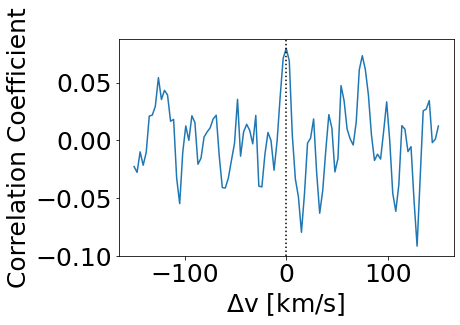

In [12]:
plt.figure()
plt.plot(rv_grid, ccf[0,0])
plt.axvline(0, color="k", linestyle=":")
plt.xlabel(r"$\Delta$v [km/s]")
plt.ylabel("Correlation Coefficient")

## Step 10: Looks like we have a detection! A detection shows up as a spike at zero in the CCF. 
## Now we will compute a detection significance using the built-in SPECTR function

In [13]:
# integrate the ccf (only for multiple exposures, it doesn't matter in this example)
# integrate ccf
ccf_integrated = np.sum(np.sum(ccf, axis=0), axis=0)


# First we'll run a hipass filter over the CCF to get rid of any aliasing that may be present
# do a hipass on the ccf
nbin = 10
bins = int(len(rv_grid) / nbin)
xb = np.arange(nbin)*bins + bins/2.0
yb = np.zeros(nbin+2)

xb = np.append(np.append(0,xb),len(rv_grid)-1)

for ib in range(nbin):
    imin = int(ib*bins)
    imax = int(imin + bins)
    yb[ib+1] = np.mean(ccf_integrated[imin:imax])
cs_bin = splrep(xb,yb,s=0.0)
fit = splev(np.arange(len(rv_grid)),cs_bin,der=0)
ccf_hipass = ccf_integrated - fit

In [14]:
cc_sig = hrt.cross_correlation.calc_significance_chi2(ccf_hipass, rv_grid, trail_bound=5)

In [15]:
print("Our detection significance is", cc_sig)

Our detection significance is 4.081453301894303


# Congrats, this is the end of the tutorial!
## Of course, this shows just the bare minimum of what SPECTR can do. For now, please feel free to explore the source code, and I hope to write more comprehensive tutorials in the future. Please get in touch with me if you have any questions or spot any errors. Thank you for reading! 